In [68]:
%pip install -q pandas networkx scikit-learn pymongo nltk pydantic uvicorn fastapi seaborn requests openpyxl

Note: you may need to restart the kernel to use updated packages.


In [69]:
from pathlib import Path
import sys

# add the repo root (…/service) so `models` is importable
ROOT = Path("..").resolve()        # points to service/
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from models.graph import company_affiliation

In [70]:
import json
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

BASE_DIR = Path("..")          # adjust if notebook is somewhere else
PEOPLE_PATH = BASE_DIR / "data" / "people.json"

with PEOPLE_PATH.open("r", encoding="utf-8") as f:
    people = json.load(f)

len(people), people[0].keys()

(148,
 dict_keys(['_id', 'name', 'company', 'role', 'schools', 'skills', 'keywords', 'seniority', 'connections', 'embedding']))

In [71]:
import openpyxl
def get_list(x, key):
    v = x.get(key, [])
    if isinstance(v, list):
        return v
    return []

rows = []
for p in people:
    _id = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    rows.append({
        "id": _id,
        "name": p.get("name", ""),
        "company": p.get("company", ""),
        "role": p.get("role", ""),
        "seniority": p.get("seniority", "Other"),
        "n_schools": len(get_list(p, "schools")),
        "n_skills": len(get_list(p, "skills")),
        "n_keywords": len(get_list(p, "keywords")),
        "n_connections": len(p.get("connections", [])),
    })

df = pd.DataFrame(rows)
df.head()


,id,name,company,role,seniority,n_schools,n_skills,n_keywords,n_connections
0,travis_liu,Travis Liu,RBC,Software Engineer in Test,Other,1,18,5,7
1,kristina_z_16412b2a7,Kristina Zaporozhets,Scotiabank,Global Analytics and Financial Engineer Intern,Student/Intern,1,9,5,15
2,ngoc_vien_do_991273gs1,Ngoc Vien Do,,Software Developer,Entry,1,6,0,10
3,andrewnt219,Andrew Nguyen,KPMG Canada,Software Engineer,Entry,1,10,5,10
4,tanise_lacasse_cpa_ca_5ab67640,"Tanise Lacasse, CPA, CA",KPMG Canada,Partner,Manager+,1,10,5,10


In [72]:
# # List of names you want to extract
# names = ["Daniela Rivera", "Michelle Clarke", "Ananya Das", "Matthew O’Reilly"]

# # Filter rows
# selected = df[df["name"].isin(names)][["name", "company", "role", "seniority",
#                                       "n_schools", "n_skills", "n_keywords"]]

# # Save to CSV
# selected.to_csv("selected_people.csv", index=False)

# # Save to Excel
# selected.to_excel("selected_people.xlsx", index=False)

# selected

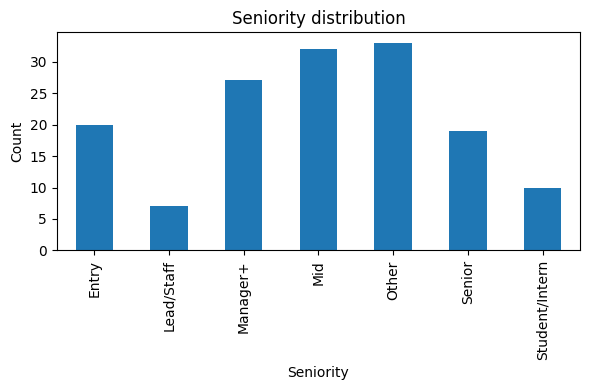

In [73]:
plt.figure(figsize=(6,4))
df["seniority"].value_counts().sort_index().plot(kind="bar")
plt.title("Seniority distribution")
plt.xlabel("Seniority")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [74]:
# if "G" not in globals():
#     from models.graph import build_graph
#     G = build_graph(people)

In [75]:
rows = []
for u, v, data in G.edges(data=True):
    rows.append({
        "u": u,
        "v": v,
        "u_name": G.nodes[u].get("name", u),
        "v_name": G.nodes[v].get("name", v),
        "skill_overlap": data.get("skill_overlap", 0),
        "relationship_strength": data.get("relationship_strength", 0),
        "company_affinity": data.get("company_affinity", 0),
        "edge_weight": data.get("weight", 0),
    })

edges_df = pd.DataFrame(rows)
edges_df.head()


,u,v,u_name,v_name,skill_overlap,relationship_strength,company_affinity,edge_weight
0,travis_liu,td_sre_01,Travis Liu,Arjun Singh,0,0,0,0.95
1,travis_liu,cris_huynh_2a52b5274,Travis Liu,Cris Huynh,0,0,0,0.95
2,travis_liu,khoivu,Travis Liu,Khoi Vu,0,0,0,0.95
3,travis_liu,ngoc_vien_do_991273gs1,Travis Liu,Ngoc Vien Do,0,0,0,0.95
4,travis_liu,uber_pm_03,Travis Liu,Rachel Kim,0,0,0,0.71


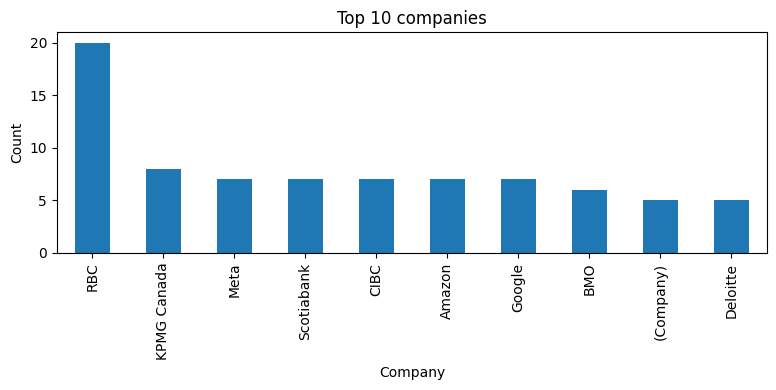

In [76]:
plt.figure(figsize=(8,4))
df["company"].replace("", "Unknown").value_counts().head(10).plot(kind="bar")
plt.title("Top 10 companies")
plt.xlabel("Company")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

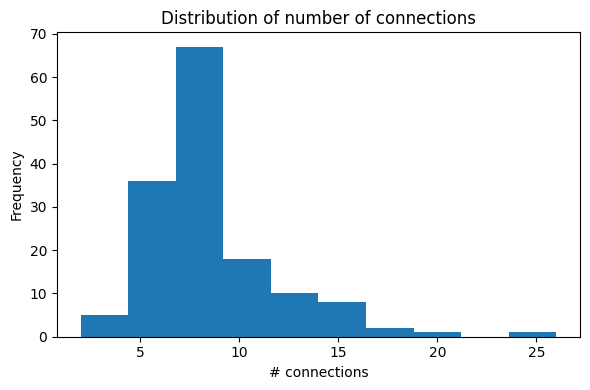

,name,n_connections
43,Cris Huynh,26
33,Gurmehak Kaur Uppal,20
137,Robert Chan,18
13,Angel Shinh,18
74,Carlos Martinez,16
1,Kristina Zaporozhets,15
145,Amanda Li,15
136,Jason Li,15
14,Jay Vakil,14
53,Liam Barker,14


In [77]:
plt.figure(figsize=(6,4))
df["n_connections"].plot(kind="hist", bins=10)
plt.title("Distribution of number of connections")
plt.xlabel("# connections")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

df[["name", "n_connections"]].sort_values("n_connections", ascending=False).head(10)

In [78]:
G = nx.Graph()

# Add nodes with attributes
for p in people:
    pid = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    G.add_node(
        pid,
        name=p.get("name", ""),
        company=p.get("company", ""),
        seniority=p.get("seniority", "Other"),
    )

# Add edges from connections field
for p in people:
    pid = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    conns = p.get("connections", []) or []
    for c in conns:
        tgt = c.get("to")
        if not tgt:
            continue
        strength = c.get("strength", 1.0)
        # Undirected graph; you can switch to DiGraph if you want direction
        G.add_edge(pid, tgt, weight=strength, tags=tuple(c.get("tags", [])))

G.number_of_nodes(), G.number_of_edges()

(148, 627)

In [79]:
import networkx as nx
help(nx.spring_layout)
print(nx.spring_layout.__doc__)

Help on function spring_layout in module networkx.drawing.layout:

spring_layout(G, k=None, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=None)
    Position nodes using Fruchterman-Reingold force-directed algorithm.
    
    The algorithm simulates a force-directed representation of the network
    treating edges as springs holding nodes close, while treating nodes
    as repelling objects, sometimes called an anti-gravity force.
    Simulation continues until the positions are close to an equilibrium.
    
    There are some hard-coded values: minimal distance between
    nodes (0.01) and "temperature" of 0.1 to ensure nodes don't fly away.
    During the simulation, `k` helps determine the distance between nodes,
    though `scale` and `center` determine the size and place after
    rescaling occurs at the end of the simulation.
    
    Fixing some nodes doesn't allow them to move in the simulation.
    It also turns off th

### Explaination:
This is small sub-graph that shows one main person with all their direct connections (friends, teammates, classmates). The connections between those people, not just to the ego. Line thickness is presenting how strong the relationship is. Node color is indicated which group/company/cluster they belong to

https://en.wikipedia.org/wiki/Force-directed_graph_drawing

https://networkx.org/documentation/networkx-1.11/reference/generated/networkx.drawing.layout.fruchterman_reingold_layout.html

https://noesis.ikor.org/wiki/algorithms/visualization#h.p_d8oCA05tzRbA

**Fruchterman-Reingold** is a force-directed graph drawing algorithm that visually represents networks by simulating a physical system where nodes are connected by springs

#### How the Algorithm Works?
A force-directed layout treats the graph like a physical system: nodes push away from each other, while connections act like springs that pull related people closer. As the algorithm iterates, these push–pull forces naturally position everyone into meaningful clusters based on how strongly they are connected. The layout stabilizes when forces balance out, creating a readable map where tightly connected groups form close together and weakly related nodes drift outward. This produces an intuitive visual of the network without manually placing any node.


#### Why Use Force-Directed Layout?
This layout is ideal because it automatically reveals the hidden structure of the career network, who clusters together, who bridges between communities, and where strong vs. weak relationships appear. Stronger ties naturally move closer, helping highlight trusted connections, classmates, teammates, and close referrals. At the same time, weak or distant relationships are spaced out, making the graph far less cluttered and easier to interpret. Overall, it gives viewers a clear visual snapshot of the user’s reachable network and potential connection paths.


#### Take it as an example about Sean Muniz's connection
Sean has strong links with Cris Huynh, Maksym Volkovynskyi, and Ngoc Vien Do due to shared school, friends, and project history. The colors represent different clusters such as companies or communities, making it easy to see how Sean’s connections interact with each other. This visualization helps identify tight-knit groups, strong bonds, and the structure of a person’s immediate network.

+ Use Force-Directed Graph Layout (Fruchterman–Reingold), the most common technique in network science that visually represents networks by simulating a physical system where nodes are connected by springs.
+ Nodes repel each other while connected nodes attract, producing an intuitive map of relationships.
+ Stronger relationships create thicker edges and tighter clusters, revealing communities and influencers.

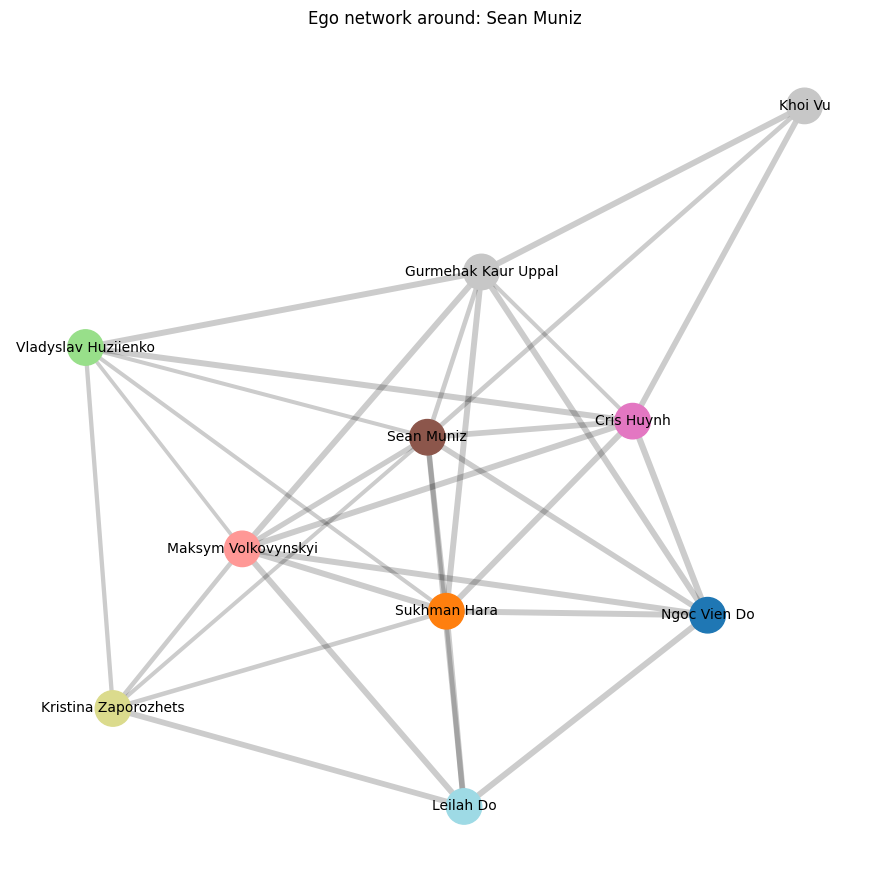

In [80]:
center_id = "sean-muniz-1b0b4a372" 

# Ego network radius size (direct neighbors)
# Radius ith represent the all ith connections
ego = nx.ego_graph(G, center_id, radius=1)

pos = nx.spring_layout(ego, seed=10, k=1.2)

plt.figure(figsize=(9, 9))

# Node colors by company (just simple mapping)
companies = [G.nodes[n].get("company", "") for n in ego.nodes()]
unique_companies = {c: i for i, c in enumerate(sorted(set(companies)))}
node_colors = [unique_companies[c] for c in companies]

strong_edges = []    
strong_widths = [] 
edge_widths = []
for u, v in ego.edges():
    data = G[u][v]       
    rel = data.get("relationship_strength", data.get("weight", 0.0))
    if rel > 0.5:
        strong_edges.append((u, v))
        strong_widths.append(0.5 + 4 * rel)

nx.draw_networkx_nodes(ego, pos, node_size=650, node_color=node_colors, cmap="tab20")
nx.draw_networkx_edges(ego, pos, edgelist=strong_edges, width=strong_widths, alpha=0.2)
nx.draw_networkx_labels(ego, pos, labels={n: G.nodes[n].get("name", n) for n in ego.nodes()}, font_size=10)

plt.title(f"Ego network around: {G.nodes[center_id]['name']}")
plt.axis("off")
plt.tight_layout()
plt.show()

## Visualize Connection

In [81]:
df_corr = df[["n_skills", "n_keywords", "n_connections"]]
df_corr.corr()

,n_skills,n_keywords,n_connections
n_skills,1.000000,0.366153,0.419148
n_keywords,0.366153,1.000000,0.268725
n_connections,0.419148,0.268725,1.000000


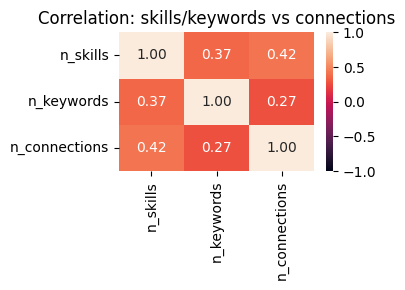

In [82]:
import seaborn as sns

plt.figure(figsize=(4,3))
sns.heatmap(df_corr.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation: skills/keywords vs connections")
plt.tight_layout()
plt.show()

## Network Plot

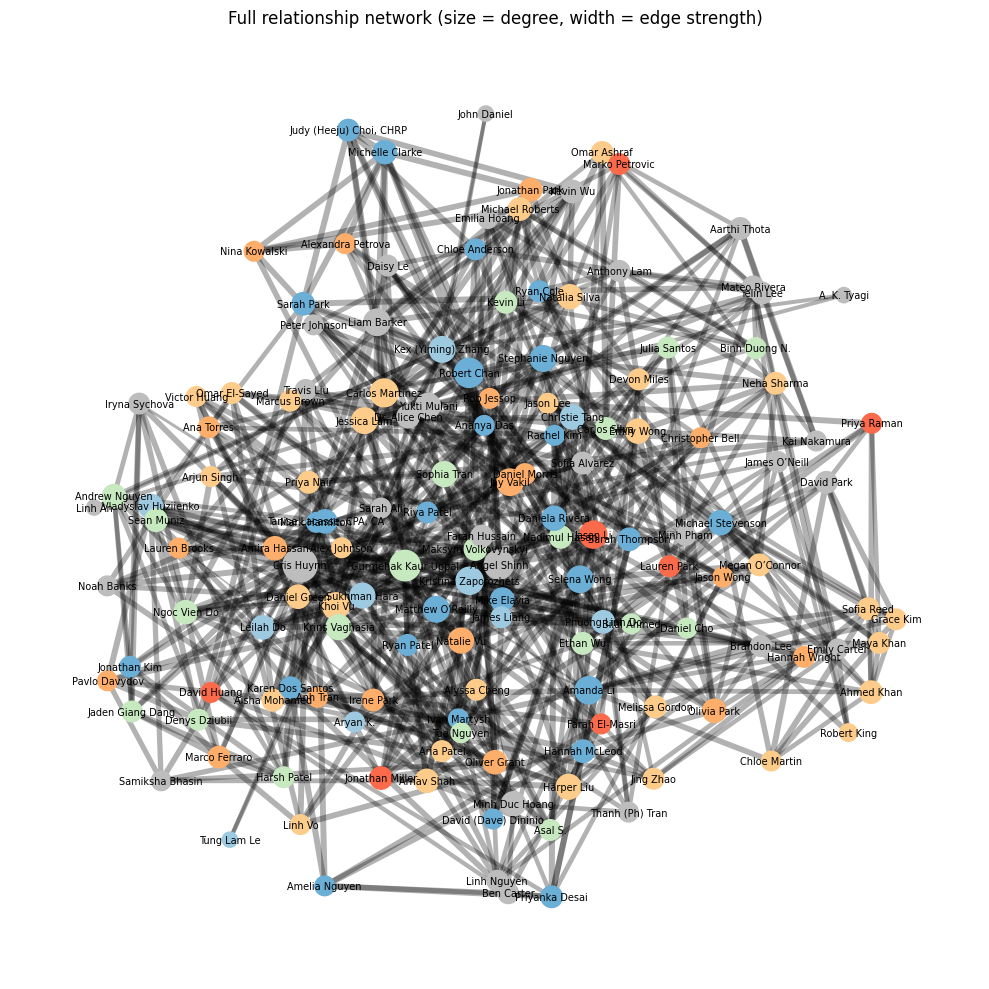

In [83]:
# Layout for the whole graph
pos = nx.spring_layout(G, k=0.8, seed=42)  # tweak k if it’s too cramped

# Node sizes = degree
degrees = dict(G.degree())
node_sizes = [80 + 20 * degrees[n] for n in G.nodes()]

# Node colors = seniority
seniority_palette = {
    "Student/Intern": "#9ecae1",
    "Entry":          "#c7e9c0",
    "Mid":            "#fdcc8a",
    "Senior":         "#fdae6b",
    "Lead/Staff":     "#fb6a4a",
    "Manager+":       "#6baed6",
    "Founder":        "#31a354",
    "Other":          "#bdbdbd",
}
node_colors = [
    seniority_palette.get(G.nodes[n].get("seniority", "Other"), "#bdbdbd")
    for n in G.nodes()
]

# Edge widths = weight (normalized)
weights = [d.get("weight", 1.0) for _, _, d in G.edges(data=True)]
if weights:
    max_w = max(weights)
    edge_widths = [0.5 + 4.0 * (w / max_w) for w in weights]
else:
    edge_widths = 1.0

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_widths)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_labels(
    G,
    pos,
    labels={n: G.nodes[n].get("name", n) for n in G.nodes()},
    font_size=7,
)

plt.title("Full relationship network (size = degree, width = edge strength)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [84]:
edge_rows = []
for u, v, d in G.edges(data=True):
    edge_rows.append({
        "from_id": u,
        "from_name": G.nodes[u].get("name", u),
        "to_id": v,
        "to_name": G.nodes[v].get("name", v),
        "weight": d.get("weight", 1.0),
        "signals": ", ".join(map(str, d.get("signals", d.get("tags", [])))),
    })

edges_df = pd.DataFrame(edge_rows)
edges_df_sorted = edges_df.sort_values("weight", ascending=False)

print("Top 10 strongest edges:")
display(edges_df_sorted.head(10))

print("Top 10 weakest edges:")
display(edges_df_sorted.tail(10))

Top 10 strongest edges:


,from_id,from_name,to_id,to_name,weight,signals
22,ngoc_vien_do_991273gs1,Ngoc Vien Do,cris_huynh_2a52b5274,Cris Huynh,1.00,"close_friend_group, highschool_friend"
0,travis_liu,Travis Liu,td_sre_01,Arjun Singh,0.95,"same_company_uber, same_function_devops, same_..."
320,sophia_tran_rbc_dev,Sophia Tran,rbc_fe_01,Jessica Lam,0.95,"same_city_toronto, same_function_software, sam..."
341,liam_barker_bmo_quant,Liam Barker,rbc_vp_digital_01,Michelle Clarke,0.95,"same_city_toronto, same_company_university_of_..."
340,liam_barker_bmo_quant,Liam Barker,kpmg_ta_director_01,Robert Chan,0.95,"same_city_toronto, same_company_university_of_..."
330,daniel_cho_scotia_data,Daniel Cho,rbc_ds_03,Emily Wong,0.95,"same_city_toronto, same_function_data, same_sc..."
329,daniel_cho_scotia_data,Daniel Cho,scotia_ds_02,Olivia Park,0.95,"same_city_toronto, same_company_scotiabank, sa..."
328,daniel_cho_scotia_data,Daniel Cho,scotia_head_campus_01,Daniela Rivera,0.95,"same_city_toronto, same_company_scotiabank, sa..."
1,travis_liu,Travis Liu,cris_huynh_2a52b5274,Cris Huynh,0.95,"same_function_devops, same_function_software, ..."
343,liam_barker_bmo_quant,Liam Barker,google_research_03,Dr. Alice Chen,0.95,"same_city_toronto, same_company_university_of_..."


Top 10 weakest edges:


,from_id,from_name,to_id,to_name,weight,signals
20,kristina_z_16412b2a7,Kristina Zaporozhets,ngoc_vien_do_991273gs1,Ngoc Vien Do,0.40,seneca_project_group
132,jay_vakil_kpmg_19ab7da3,Jay Vakil,phuong-linh-do-7057642a5,Phuong Linh Do,0.40,connection
131,jay_vakil_kpmg_19ab7da3,Jay Vakil,amanda_li_pwc_2712xx91,Amanda Li,0.40,cross_firm_project_partner
44,tanise_lacasse_cpa_ca_5ab67640,"Tanise Lacasse, CPA, CA",iryna_sychova,Iryna Sychova,0.40,"kpmg_finance_team, organizational_network"
47,tanise_lacasse_cpa_ca_5ab67640,"Tanise Lacasse, CPA, CA",cris_huynh_2a52b5274,Cris Huynh,0.30,"organizational_network, senior_leader_kpmg"
48,tanise_lacasse_cpa_ca_5ab67640,"Tanise Lacasse, CPA, CA",amanda_li_pwc_2712xx91,Amanda Li,0.25,cross_firm_tax_network
61,minhduc_hoang,Minh Duc Hoang,cris_huynh_2a52b5274,Cris Huynh,0.20,mentee
297,cris_huynh_2a52b5274,Cris Huynh,amanda_li_pwc_2712xx91,Amanda Li,0.20,industry_event_connection
39,andrewnt219,Andrew Nguyen,minhduc_hoang,Minh Duc Hoang,0.15,software_engineering_network
21,kristina_z_16412b2a7,Kristina Zaporozhets,minhduc_hoang,Minh Duc Hoang,0.10,academic_network


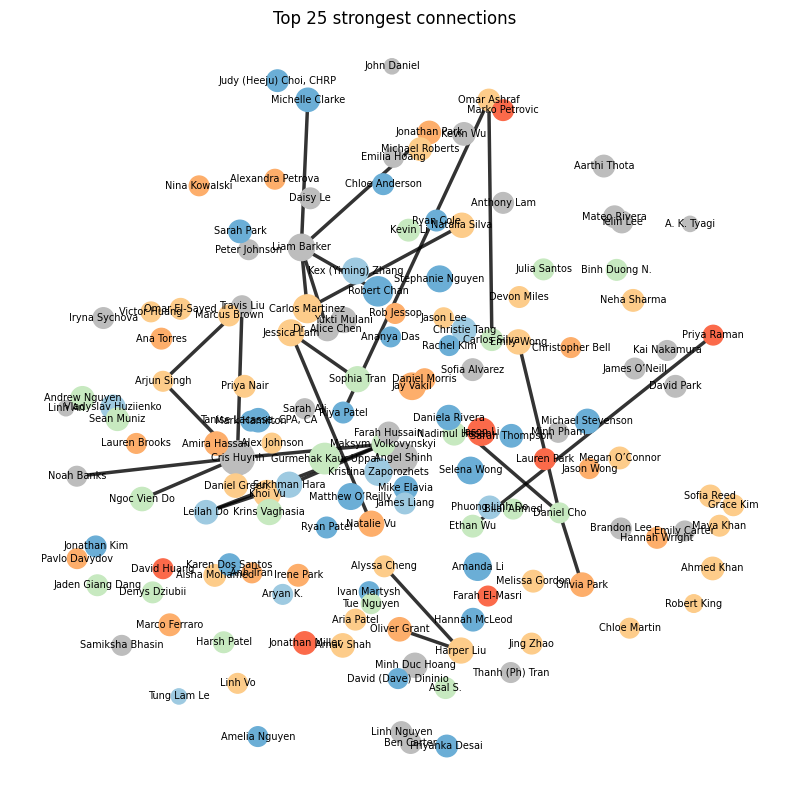

In [85]:
top_k = 25
strong_edges = list(
    zip(
        edges_df_sorted.head(top_k)["from_id"],
        edges_df_sorted.head(top_k)["to_id"],
    )
)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=strong_edges, width=2.5, alpha=0.8)
nx.draw_networkx_labels(
    G,
    pos,
    labels={n: G.nodes[n].get("name", n) for n in G.nodes()},
    font_size=7,
)
plt.title(f"Top {top_k} strongest connections")
plt.axis("off")
plt.tight_layout()
plt.show()

## Predict the factor by using features

In [86]:
def get_list(x, key):
    v = x.get(key, [])
    return v if isinstance(v, list) else []

rows = []
for p in people:
    pid = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    rows.append({
        "id": pid,
        "name": p.get("name", ""),
        "company": p.get("company", ""),
        "role": p.get("role", ""),
        "seniority": p.get("seniority", "Other"),
        "n_schools": len(get_list(p, "schools")),
        "n_skills": len(get_list(p, "skills")),
        "n_keywords": len(get_list(p, "keywords")),
        "n_connections": len(p.get("connections", [])),
    })

df = pd.DataFrame(rows)
df.head()

,id,name,company,role,seniority,n_schools,n_skills,n_keywords,n_connections
0,travis_liu,Travis Liu,RBC,Software Engineer in Test,Other,1,18,5,7
1,kristina_z_16412b2a7,Kristina Zaporozhets,Scotiabank,Global Analytics and Financial Engineer Intern,Student/Intern,1,9,5,15
2,ngoc_vien_do_991273gs1,Ngoc Vien Do,,Software Developer,Entry,1,6,0,10
3,andrewnt219,Andrew Nguyen,KPMG Canada,Software Engineer,Entry,1,10,5,10
4,tanise_lacasse_cpa_ca_5ab67640,"Tanise Lacasse, CPA, CA",KPMG Canada,Partner,Manager+,1,10,5,10


In [87]:
num_cols = ["n_schools", "n_skills", "n_keywords", "n_connections"]
corr = df[num_cols].corr()
corr

,n_schools,n_skills,n_keywords,n_connections
n_schools,1.000000,0.061299,0.044181,0.012523
n_skills,0.061299,1.000000,0.366153,0.419148
n_keywords,0.044181,0.366153,1.000000,0.268725
n_connections,0.012523,0.419148,0.268725,1.000000


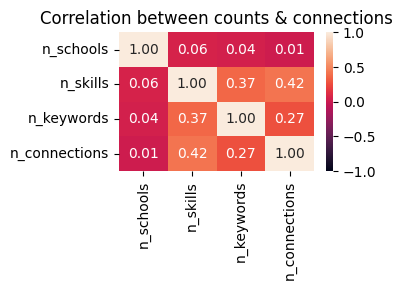

In [88]:
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation between counts & connections")
plt.tight_layout()
plt.show()

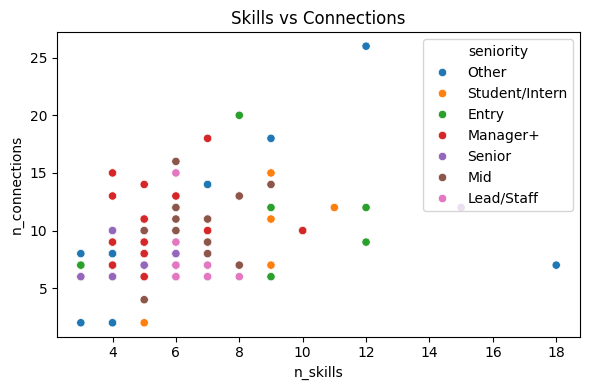

In [89]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x="n_skills",
    y="n_connections",
    hue="seniority",
)
plt.title("Skills vs Connections")
plt.tight_layout()
plt.show()

## Regression

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

X = df[["n_schools", "n_skills", "n_keywords", "seniority"]]
y = df["n_connections"]

numeric_features = ["n_schools", "n_skills", "n_keywords"]
categorical_features = ["seniority"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression()),
    ]
)

model.fit(X, y)
y_pred = model.predict(X)

print("R^2 on this dataset:", r2_score(y, y_pred))
lin = model.named_steps["regressor"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"]

cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

coefs = pd.Series(lin.coef_, index=feature_names).sort_values(ascending=False)
coefs

R^2 on this dataset: 0.21792829300422112


seniority_Manager+          1.494305
n_skills                    0.608368
seniority_Mid               0.284569
seniority_Other             0.266831
n_keywords                  0.242125
seniority_Student/Intern    0.232844
seniority_Senior            0.086646
n_schools                  -0.210795
seniority_Lead/Staff       -0.619977
dtype: float64